In [1]:
import nlcc
import glob
import time
import pandas as pd
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
base_colors = ["e63946","f1faee","a8dadc","457b9d","1d3557"]
colors = ['#' + c for c in base_colors]
sns.set_style("white")
sns.set_style("ticks")
sns.set(rc={'axes.facecolor':'#f5f4e9', 
            'grid.color' : '#AAAAAA', 
            'axes.edgecolor':'#333333', 
            'figure.facecolor':'#FFFFFF', 
            'axes.grid': False,
            'axes.prop_cycle':   plt.cycler('color', plt.cm.Dark2.colors),
            'font.family': 'monospace'
           })

## Load Prompts

In [2]:
topic_categories = ['md', 'spectroscopy', 'bio', 'qm', 'sim', 'cheminf', 'genchem', 'thermo', 'stats', 'plot']
code_categories = ['code', 'human']
lang_categories = ['ch']
keys = ['name', 'language', 'context']

In [3]:
data = None
valid_files = []
def insert_row(r, data):
    if data is None:
        return {k: [v] for k,v in r.items()}
    return  {k: v + [r[k]] for k,v in data.items()}
for fn in glob.glob('../data/**/*.yml'):
    with open(fn, 'r') as f:
        d = yaml.safe_load(f)
        # slice        
        cat_str = d['categories'] 
        d = {k: d[k] for k in keys}
        # duplicate for categories
        tcs = [c for c in topic_categories if c in cat_str]
        ccs = [c for c in code_categories if c in cat_str]
        lcs = [c for c in lang_categories if c in cat_str]
        if len(lcs) == 0:
            lcs = ['en']
        if len(tcs) > 0:
            valid_files.append(fn)
        for tc in tcs:
            for cc in ccs:
                for lc in lcs:
                    d.update({'topic': tc, 'type': cc, 'natlang': lc})                    
                    data = insert_row(d, data)
                    
df = pd.DataFrame.from_dict(data)

In [4]:
df.groupby('topic').count()

,name,language,context,type,natlang
topic,,,,,
bio,12,12,12,12,12
cheminf,10,10,10,10,10
genchem,11,11,11,11,11
md,8,8,8,8,8
plot,10,10,10,10,10
qm,6,6,6,6,6
sim,4,4,4,4,4
spectroscopy,6,6,6,6,6
stats,9,9,9,9,9


In [13]:
m

'incoder/facebook/incoder-1B'

## Programmatic Prompts

In [50]:
paths = ' '.join(valid_files[:3])
temperatures = [0.05, 0.2, 0.5]
models = ['openai/code-cushman-001', 'openai/code-davinci-002', 'incoder/facebook/incoder-1B']
model_names = ['cushman', 'davinci', 'incoder-1B']
can_insert = [False, True, True]
#models = ['incoder/facebook/incoder-1B']
#model_names = ['incoder-1B']
#can_insert = [True]
k = 2
for i,t in enumerate(temperatures):
    for ins, m, mn in zip(can_insert, models, model_names):
        out = f'override_{mn}_{i}.csv'
        print(out)
        !nlcc-bench $paths $out --n $k --prompt python --temperature $t --engine $m
        out = f'bench_{mn}_{i}.csv'
        !nlcc-bench $paths $out --n $k --temperature $t --engine $m
        if ins:
            out = f'insert_bench_{mn}_{i}.csv'
            !nlcc-bench $paths $out --n $k --prompt insert --temperature $t --engine $m
        out = f'cheader_bench_{mn}_{i}.csv'
        insert_text = '-insert' if ins else ''
        header = f'header{insert_text}:# MIT License\n\n# Copyright (c) 2022 Regents of the University of California\n\n'
        !nlcc-bench $paths $out --n $k --prompt "$header" --temperature $t --engine $m
        out = f'lheader_bench_{mn}_{i}.csv'
        header = f'header{insert_text}:# This is written by an expert Python programmer\n\n'
        !nlcc-bench $paths $out --n $k --prompt "$header" --temperature $t --engine $m

NameError: name 'fdsa' is not defined

In [51]:
merged = None
for i,t in enumerate(temperatures):
    for ins, m, mn in zip(can_insert, models, model_names):
        f = f'override_{mn}_{i}.csv'
        bf = pd.read_csv(f, delim_whitespace=True)    
        bf = pd.merge(bf, df, how='inner', on='name')
        bf.context.values[:] = 'none'
        if merged is None:
            merged = bf
        else:
            merged = pd.concat((merged, bf))
        f = f'bench_{mn}_{i}.csv'
        bf = pd.read_csv(f, delim_whitespace=True)    
        bf = pd.merge(bf, df, how='inner', on='name')
        merged = pd.concat((merged, bf))
        if ins:
            f = f'insert_bench_{mn}_{i}.csv'
            bf = pd.read_csv(f, delim_whitespace=True) 
            bf = pd.merge(bf, df, how='inner', on='name')
            bf.context.values[:] = [v + '-insert' for v in bf.context.values[:]]
            merged = pd.concat((merged, bf))
        f = f'cheader_bench_{mn}_{i}.csv'
        bf = pd.read_csv(f, delim_whitespace=True)    
        bf = pd.merge(bf, df, how='inner', on='name')
        bf.context.values[:] = [v + '-copyright' for v in bf.context.values[:]]
        merged = pd.concat((merged, bf))
        f = f'lheader_bench_{mn}_{i}.csv'
        bf = pd.read_csv(f, delim_whitespace=True)    
        bf = pd.merge(bf, df, how='inner', on='name')
        bf.context.values[:] = [v + '-authority' for v in bf.context.values[:]]
        merged = pd.concat((merged, bf))
def short_context(c):
    if c == 'none':
        return c
    elif 'copyright' in c:
        return 'copyright'
    elif 'authority' in c:
        return 'authority'
    elif 'insert' in c:
        return 'insert'
    return 'custom'

def short_model(c):
    i = models.index(c)
    return model_names[i]
    
merged = merged.assign(used_context=merged.context.apply(short_context))
merged = merged.assign(model=merged.engine.apply(short_model))
merged.to_pickle('promp_results.pkl')
merged.tail()

,name,result,temperature,engine,language,context,topic,type,natlang,used_context,model
1,aa_polarity,0,0.5,incoder/facebook/incoder-1B,python,python-authority,bio,code,en,authority,incoder-1B
2,adiabatic_expansion,0,0.5,incoder/facebook/incoder-1B,python,python-authority,thermo,code,en,authority,incoder-1B
3,adiabatic_expansion,0,0.5,incoder/facebook/incoder-1B,python,python-authority,thermo,code,en,authority,incoder-1B
4,alignment,0,0.5,incoder/facebook/incoder-1B,python,mdtraj-authority,md,code,en,authority,incoder-1B
5,alignment,0,0.5,incoder/facebook/incoder-1B,python,mdtraj-authority,md,code,en,authority,incoder-1B


/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/seaborn/axisgrid.py:675: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


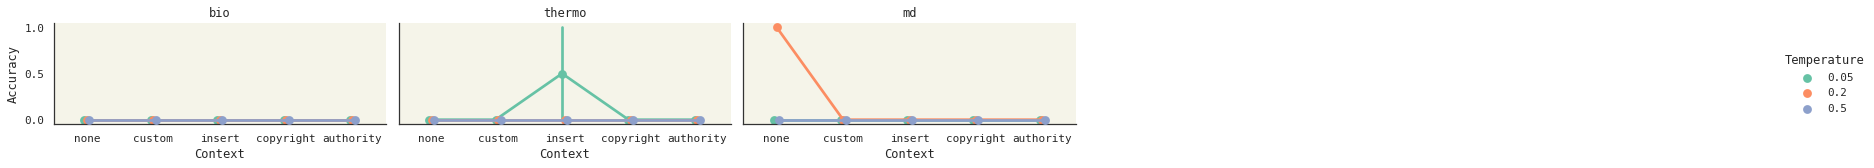

In [56]:
plt.figure(figsize=(4,4), dpi=90)
g = sns.FacetGrid(merged[merged.model == 'incoder-1B'], col='topic', col_wrap=5, height=2.5, aspect=2, hue_order=temperatures)
g.map(sns.pointplot, 'used_context', 'result', 'temperature', 
      palette='Set2', dodge=True)
g.add_legend(title='Temperature')
g.set_axis_labels('Context', 'Accuracy')
g.set_titles('{col_name}')
g.savefig('accuracy.pdf')
g.savefig('accuracy.png')

/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/seaborn/axisgrid.py:675: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


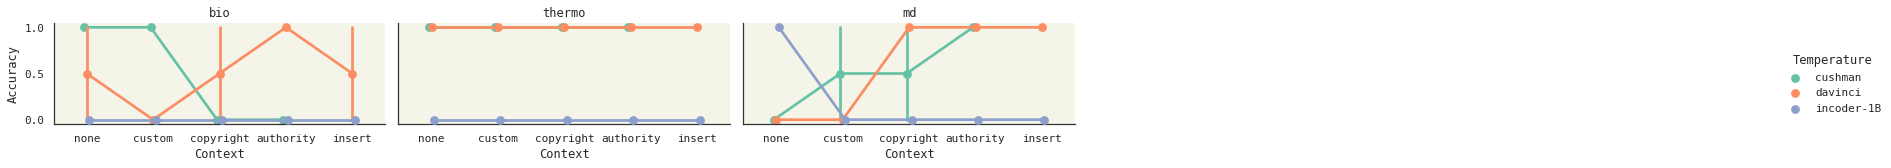

In [55]:
plt.figure(figsize=(4,4), dpi=90)
g = sns.FacetGrid(merged[merged.temperature == 0.2], col='topic', col_wrap=5, height=2.5, aspect=2, hue_order=model_names)
g.map(sns.pointplot, 'used_context', 'result', 'model', 
      palette='Set2', dodge=True)
g.add_legend(title='Temperature')
g.set_axis_labels('Context', 'Accuracy')
g.set_titles('{col_name}')
g.savefig('accuracy.pdf')
g.savefig('accuracy.png')

In [9]:
print(df.groupby('topic').count().iloc[:,0].to_latex())

\begin{tabular}{lr}
\toprule
{} &  name \\
topic        &       \\
\midrule
bio          &    12 \\
cheminf      &    10 \\
genchem      &    11 \\
md           &     8 \\
plot         &    10 \\
qm           &     6 \\
sim          &     4 \\
spectroscopy &     6 \\
stats        &     9 \\
thermo       &    10 \\
\bottomrule
\end{tabular}



/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/seaborn/axisgrid.py:675: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


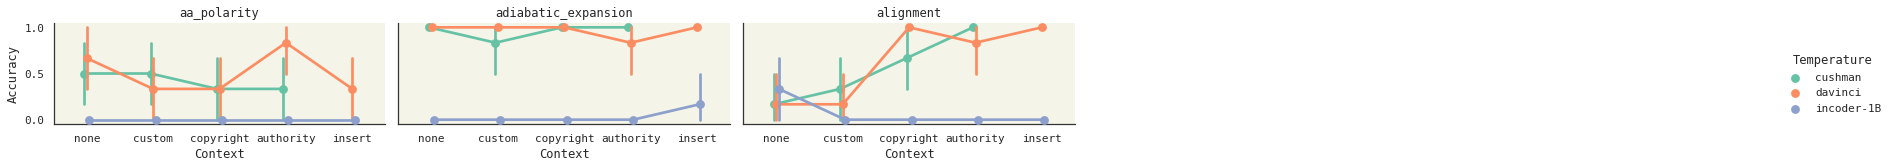

In [64]:
plt.figure(figsize=(4,4), dpi=90)
g = sns.FacetGrid(merged, col='name', col_wrap=5, height=2.5, aspect=2, hue_order=temperatures)
g.map(sns.pointplot, 'used_context', 'result', 'model', 
      palette='Set2', dodge=True)
g.add_legend(title='Temperature')
g.set_axis_labels('Context', 'Accuracy')
g.set_titles('{col_name}')
g.savefig('all.pdf')
g.savefig('all.png')

/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/seaborn/categorical.py:3775: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try barplot
  warnings.warn(msg, UserWarning)


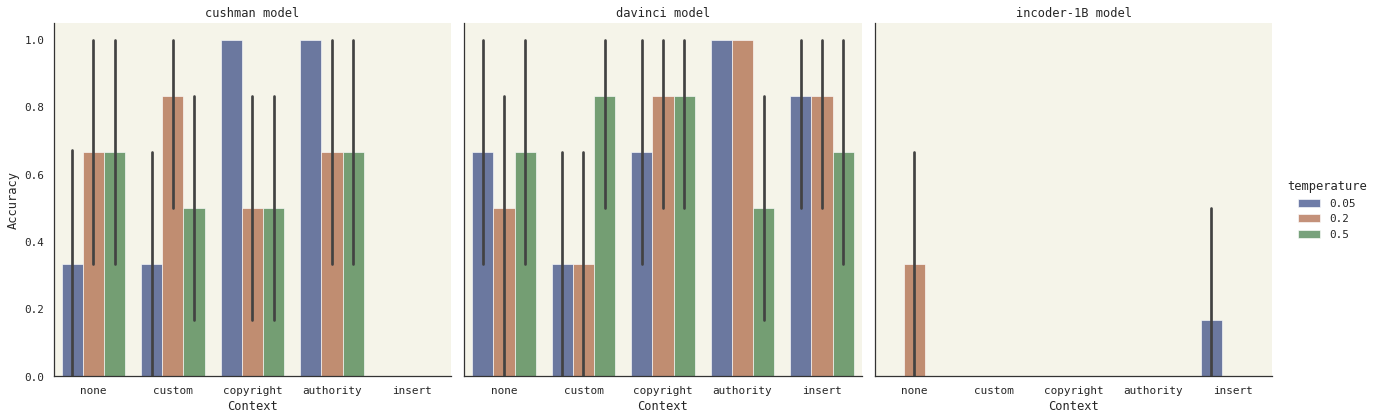

In [63]:
g = sns.catplot(
    data=merged, kind="bar", col="model",
    x="used_context", y="result", hue="temperature",
    palette="dark", alpha=.6, height=6, ax=axs[0]
)
g.set_axis_labels('Context', 'Accuracy')
g.set_titles('{col_name} model')
g.savefig('context.pdf')